## CNN Modeling of CMB Foregrounds
The goal of this project is to use a Convolutional Neural Network (CNN) to predict the foreground contamination of a Cosmic Microwave Background (CMB) map. The training data will be maps of foreground models created using the Python Sky Model (PySM3). The training data will consist of maps of multiple frequency bands and both Q and U polarization modes and the Temperature mode to make up input channels. The training data will be found by randomly(?) selecting a region on an all-sky map, and convoluting together pixels in the selected region and across the frequency/polarization channels. After the model is trained, it will be fed a contaminated CMB map and attempt to get rid of the present foregrounds.

# Set Device

In [ ]:
COLAB_FOLDER = 'ML' # change as needed
GITHUB_USER  = 'hbprosper'
GITHUB_REPO  = 'mlinphysics'
GITHUB_FOLDERS = ['mlinphysics']
#------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    print('\nGoogle Drive mounted\n')
    IN_COLAB = True
except:
    print('\nRunning locally\n')
    IN_COLAB = False

if IN_COLAB:
    MYDRIVE     = '/content/gdrive/MyDrive'
    GITHUB_BASE = 'https://raw.githubusercontent.com'
    MAIN        = 'refs/heads/main'
    GITHUB_PATH = f'{MYDRIVE}/{COLAB_FOLDER}'
    #------------------------------------------------------
    %cd {GITHUB_PATH}
    %rm -f {GITHUB_PATH}/clone2colab.ipynb
    !wget -q {GITHUB_BASE}/{GITHUB_USER}/{GITHUB_REPO}/{MAIN}/clone2colab.ipynb
    %run {GITHUB_PATH}/clone2colab.ipynb
    %cd /content/gdrive/MyDrive/ML/Foregrounds/

Mounted at /content/gdrive

Google Drive mounted

/content/gdrive/MyDrive/ML
/content
	1. uninstall mlinphysics
	2. sparse clone mlinphysics

/content/mlinphysics

	3. install mlinphysics

/content
/content/gdrive/MyDrive/ML/Foregrounds


# Image Creation
The CNN will be trained on square images of all sky projections from the Python Sky Model. These images will have 9 input channels, 3 for polarization (I,Q,U) and 3 for frequency (100 GHz, 217 GHz, 353 GHz).

In [ ]:
!pip install pysm3
!pip install healpy
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
import h5py
import matplotlib.pyplot as plt
import warnings
import torch

warnings.filterwarnings("ignore")

def make_foreground_maps(frequencies, strings, nside):
    sky = pysm3.Sky(nside = nside, preset_strings=strings + ["c1"])
    sky_true = pysm3.Sky(nside = nside, preset_strings = ["c1"])
    for frequency in frequencies:
        skymap = sky.get_emission(frequency*u.GHz)
        skymap = skymap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(frequency*u.GHz))
        skymap_true = sky_true.get_emission(frequency*u.GHz)
        skymap_true = skymap_true.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(frequency*u.GHz))
        hp.fitsfunc.write_map(str(frequency) + "GHz", skymap, overwrite=True)
        hp.fitsfunc.write_map(str(frequency) + "GHz_true", skymap_true, overwrite=True)


def make_images(num, res):
    #this function randomly selects a patch on the sky to use as training data. (is this a good idea? I want the position to have some impact on parameters of the model)
    #it should get a random selection, then get that section from all of the frequency bands and polarizations.
    #num is the number of images
    #res is the resolution of the image in arcminutes

    #loading all sky projections
    map_100 = hp.fitsfunc.read_map("100GHz", field = (0,1,2))
    map_217 = hp.fitsfunc.read_map("217GHz", field = (0,1,2))
    map_353 = hp.fitsfunc.read_map("353GHz", field = (0,1,2))

    map_100_true = hp.fitsfunc.read_map("100GHz_true", field = (0,1,2))
    map_217_true = hp.fitsfunc.read_map("217GHz_true", field = (0,1,2))
    map_353_true = hp.fitsfunc.read_map("353GHz_true", field = (0,1,2))

    size = 256
    image_arr = np.zeros((num, 12, size, size))

    for i in range(num):
        #random generation of lat lon angles on sky
        print("generating image " + str(i))
        lon = np.random.random() * 360
        lat = np.random.random() * 180 - 90

        #generate I map cuts
        I_100_square = hp.gnomview(map_100[0], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        I_217_square = hp.gnomview(map_217[0], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        I_353_square = hp.gnomview(map_353[0], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')

        #generate Q map cuts
        Q_100_square = hp.gnomview(map_100[1], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        Q_217_square = hp.gnomview(map_217[1], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        Q_353_square = hp.gnomview(map_353[1], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')

        #generate U map cuts
        U_100_square = hp.gnomview(map_100[2], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        U_217_square = hp.gnomview(map_217[2], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        U_353_square = hp.gnomview(map_353[2], rot = [lon, lat], reso = res, xsize = 256, return_projected_map=True, no_plot=True)
        plt.close('all')
        I_100_true = hp.gnomview(map_100_true[0], rot = [lon, lat], reso = res, xsize=256, return_projected_map=True, no_plot = True)
        plt.close()
        I_217_true = hp.gnomview(map_217_true[0], rot = [lon, lat], reso = res, xsize=256, return_projected_map=True,no_plot=True)
        plt.close()
        I_353_true = hp.gnomview(map_353_true[0], rot = [lon, lat], reso = res, xsize=256, return_projected_map=True,no_plot=True)
        plt.close('all')

        #stack the maps into one 3D array along first axis
        image_arr[i] = np.stack((I_100_square, I_217_square, I_353_square, Q_100_square, Q_217_square, Q_353_square, U_100_square, U_217_square, U_353_square, I_100_true, I_217_true, I_353_true))

        #save flattened array to text file

        del Q_100_square
        del Q_217_square
        del Q_353_square
        del U_100_square
        del U_217_square
        del U_353_square
        del I_100_square
        del I_217_square
        del I_353_square
        del I_100_true
        del I_217_true
        del I_353_true

    with h5py.File('images.h5', 'w') as hf:
        hf.create_dataset('foregrounds_images', data = image_arr)

#generate all sky projections and cuts. This only has to be done once, then can be commented out unless new foreground contaminants or cuts are desired.

#make_foreground_maps([100,217,353], ["s1", "d1"], 512)
#make_images(500, 4)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\n\tAvailable device: {str(DEVICE):4s}\n')


	Available device: cpu 



# Convolutional Neural Network Layout
The input shape of the image fed to the network is (9,200,200). The output shape should be (3,200,200) with just Temperature mode output. Going to try a simple 3 level model going to (27, 200, 200) before final step back to (3, 200, 200).

# Define Model

In [ ]:
import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat
import mlinphysics.utils.monitor as mon

#load images

with h5py.File("images.h5", "r") as f:
    images = f['foregrounds_images']
    images = images[...]

#configure model

    name = 'foregrounds'

    load_existing_config = False

    if load_existing_config:
        config = mlp.Config(f'{name}.yaml')
    else:
        config = mlp.Config(name)

        #training config
        n_images = len(images)
        batch_size = 16
        n_iters_per_epoch = 24
        train_size = n_iters_per_epoch * batch_size
        test_size = 25
        val_size = n_images - train_size - test_size

        config('batch_size', batch_size)
        config('train_size', train_size)
        config('test_size', test_size)
        config('val_size', val_size)

        config('monitor_step', 10)
        config('delete', True)
        config('frac', 0.015)

        #optimizer/scheduler

        config('n_epochs', 400)
        config('n_iters_per_epoch', n_iters_per_epoch)
        config('n_iterations', config('n_epochs') * config('n_iters_per_epoch'))
        config('n_steps', 4)
        config('n_iters_per_step', config('n_iterations') // config('n_steps'))
        config('base_lr', 1.e-3)
        config('gamma', 0.8)

        config.save()
    print(config)


    #

    print(train_size, test_size, val_size)

name: foregrounds
file:
  losses: runs/2025-11-13_0114/foregrounds_losses.csv
  params: runs/2025-11-13_0114/foregrounds_params.pth
  init_params: runs/2025-11-13_0114/foregrounds_init_params.pth
  plots: runs/2025-11-13_0114/foregrounds_plots.png
batch_size: 16
train_size: 384
test_size: 25
val_size: 91
monitor_step: 10
delete: true
frac: 0.015
n_epochs: 400
n_iters_per_epoch: 24
n_iterations: 9600
n_steps: 4
n_iters_per_step: 2400
base_lr: 0.001
gamma: 0.8

384 25 91


# Prepare Data
The true maps should be appended to the end of the contaminated map array elements. Maybe do this earlier when loading from data.

In [ ]:
print(images.shape)

ims = images[:,0:9,:,:].astype(np.float32)
targs = images[:,9:12,:,:].astype(np.float32)
latlon = images[:,12:, :, :].astype(np.float32)

#lat and lon maps get put on both the targets and the inputs
ims = np.concatenate((ims, latlon), axis = 1)
targs = np.concatenate((targs, latlon), axis = 1)

#scale data
#ims = ims / np.max(ims)
#targs = targs / np.max(targs)


(500, 14, 256, 256)
ims is nan  False
targs is nan  False
float32
float32
(500, 2, 256, 256)
(500, 11, 256, 256)
(500, 5, 256, 256)


In [ ]:
import importlib
importlib.reload(dat)

train_size = config('train_size')
val_size = config('val_size')
test_size = config('test_size')

#define datasets
print('training data')
train_data = dat.Dataset(ims, start=0, end=train_size,targets=targs,verbose=True)

print('training data for validation')
train_data_val = dat.Dataset(ims, start=0, end=train_size, targets=targs, random_sample_size=val_size)

print('validation data')
val_data = dat.Dataset(ims, start=train_size, end=train_size+val_size, targets=targs)

print('test data')
test_data = dat.Dataset(ims, start = train_size + val_size, end=train_size + val_size + test_size, targets=targs)

training data
Dataset
  shape of x: torch.Size([384, 9, 256, 256])
  shape of y: torch.Size([384, 3, 256, 256])

training data for validation
Dataset
  shape of x: torch.Size([91, 9, 256, 256])
  shape of y: torch.Size([91, 3, 256, 256])

validation data
Dataset
  shape of x: torch.Size([91, 9, 256, 256])
  shape of y: torch.Size([91, 3, 256, 256])

test data
Dataset
  shape of x: torch.Size([25, 9, 256, 256])
  shape of y: torch.Size([25, 3, 256, 256])



# DataLoaders

In [ ]:
import torch.utils.data as dt
print('train data loader')
train_loader = dt.DataLoader(train_data,
                             batch_size=config('batch_size'),
                             shuffle=True)

print('train data loader for validation')
train_loader_val = dt.DataLoader(train_data_val,
                                 batch_size=len(train_data_val))

print('validation data loader')
val_loader  = dt.DataLoader(val_data,
                            batch_size=len(val_data))

print('test data loader')
test_loader = dt.DataLoader(test_data,
                            batch_size=len(test_data))

train data loader
train data loader for validation
validation data loader
test data loader


# Build Model

In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding = 1, dropout = 0.04):
        super().__init__()
        kernel_size = 2*padding + 1 #3x3 for all convolutions for now
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=kernel_size, stride=1, padding = padding, padding_mode='circular')
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        #currently not doing any downsampling

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class ForegroundCleaner(mlp.Model):
    def __init__(self, image_size=256, channels=(11, 24, 32, 32, 32, 11, 3), padding = 1):
        super().__init__()

        nlayers = len(channels) - 1

        #number of inputs into final map layer
        #final_image_size = (image_size, image_size)
        #ninputs = channels[-1]*image_size**2

        layers = [ConvBlock(channels[i], channels[i+1], padding) for i in range(nlayers)]

        #no additional layers for now as the final layer is a convolution
        self.layers = nn.ModuleList(layers)

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x


# Instantiate Model

In [ ]:
importlib.reload(mlp)

model = ForegroundCleaner().to(DEVICE)
print(model)
print()

print('number of parameters', mlp.number_of_parameters(model))
print()

ForegroundCleaner(
  (layers): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (batchnorm): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.04, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(18, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (batchnorm): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.04, inplace=False)
    )
    (2-3): 2 x ConvBlock(
      (conv): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (batchnorm): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.04, inplace=False)
    )
    (4): ConvBlock(
      (conv): Conv2d(27, 18, kernel_size=

# Loss Function
The loss function will have 3 parts. One part is the mean of the absolute deviation between the input intensity map and the output intensity map. The second is similar but uses the amplitude of the Fourier Transform of the map. The last part will compute and compare the power spectrun between the target and the current map.

In [ ]:
import math
import sys
class LossFunction():

    def __init__(self):
        pass

    def __call__(self, outputs, targets):
        #outputs is the maps coming out of the final convolution block, shape (batch_size, 3, 256, 256)
        #targets is the same as before, the maps with no foreground contaminants (batch_size, 3, 256, 256)
        #3 terms summed together give the loss function

        #First term: The mean absolute difference between the output map and the target map
        #sum across image in batch, image pixels, and across frequency using only I maps for now

        #Take the means of the absolute difference across a single image in x and y (exclude lat and lon channels)
        #if the mean absolute difference of position channels is used, the whol outputs and targets just get included here
        #and the L_3 term can be commented out.
        L_1 = torch.mean(torch.abs(outputs[:,:3,:,:] - targets[:,:3,:,:]) / torch.max(torch.abs(outputs[:,:3,:,:] - targets[:,:3,:,:])), dim=(2,3))
        #Average across frequencies
        L_1 = torch.mean(L_1, dim = 1)
        #Average across batch size
        L_1 = torch.mean(L_1, dim = 0)

        #Second term: The mean absolute difference between the amplitudes of the Fourier transforms of the output and target maps
        #First get the amplitudes of the Fourier transforms

        L_2_arr = np.zeros((len(outputs[:,0,0,0]), len(outputs[0,:,0,0]))) #Fill as we go

        for i in range(len(outputs[:,0,0,0])): #loop over batch size
            for j in range(len(outputs[0,:,0,0]) - 2): #loop over frequencies (exclude the position channels)
                #Take the 2D FFT of both the outputs and targets
                FFT_output = torch.fft.fft2(outputs[i,j,:,:])
                FFT_target = torch.fft.fft2(targets[i,j,:,:])
                #Get the amplitudes of the FFTs
                A_output = torch.sqrt(FFT_output.real**2 + FFT_output.imag**2)
                A_target = torch.sqrt(FFT_target.real**2 + FFT_target.imag**2)
                #Get the mean of the absolute value difference of the amplitudes across each FFT map
                ans = torch.mean(torch.abs(A_output - A_target) / torch.max(torch.abs(A_target - A_output)))
                #Assign to appropriate place in array
                L_2_arr[i,j] = ans
        #Now do the average across frequency channels
        L_2 = np.mean(L_2_arr, axis = 1)
        #Now do the average across batch size
        L_2 = np.mean(L_2)

        #Third term: The mean square difference between the position maps. The aim is to make the model reconstruct the position maps on the sky
        #so that the model "knows" where it is on the sky.
        #average over x and y the square difference in lat and lon
        L_3 = torch.mean((outputs[:,3:,:,:] - targets[:,3:,:,:])**2 / torch.max((outputs[:,:3,:,:] - targets[:,3:,:,:])**2), dim=(2,3))
        #average over frequencies
        L_3 = torch.mean(L_3, dim = 1)
        #average over the batch size
        L_3 = torch.mean(L_3, dim = 0)

        L = L_1 + L_2 + L_3


        return L

# Instatiate Training Objects

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config('base_lr'))
scheduler = mlp.get_steplr_scheduler(optimizer, config)
objective = mlp.Objective(model, LossFunction())

number of milestones:          3

Step | Milestone | LR
-----------------------------
   0 |         0 | 1.0e-03   
-----------------------------
   1 |      1200 | 8.0e-04   
   2 |      2400 | 6.4e-04   
   3 |      3600 | 5.1e-04   

number of iterations:           4800



# Define Trainer

In [ ]:
def train(objective, optimizer, scheduler,
          train_loader, train_small_loader, val_loader,
          config):

    # get configuration info
    lossfile   = config('file/losses')
    paramsfile = config('file/params')
    step       = config('monitor_step')
    delete     = config('delete')
    frac       = config('frac')
    nepochs    = config('n_epochs')
    niters     = config('n_iterations')

    # instantiate object that saves average losses to
    # a csv file for realtime monitoring

    losswriter = mon.LossWriter(niters,
                                lossfile,
                                step=step,
                                delete=delete,
                                frac=frac,
                                model=objective.model,
                                paramsfile=paramsfile)

    # instantiate learning rate step scheduler
    lrscheduler = mlp.LRStepScheduler(optimizer, scheduler)

    # -----------------------------
    # training loop
    # -----------------------------
    ii = -1
    for epoch in range(nepochs):

        for x, y in train_loader:

            ii += 1

            # set mode to training so that training-specific
            # operations such as dropout, etc., are enabled.
            objective.train()

            # clear all gradients
            optimizer.zero_grad()

            # compute empirical risk
            R = objective(x, y)

            # compute gradients
            R.backward()

            # take one step downhill in the empirical risk landscape
            optimizer.step()

            # check whether to update learning rate
            lrscheduler.step()

            # I'm alive printout
            if (ii % step == 0) or (ii == niters-1):

                # compute average losses on training and validation data
                t_loss = mlp.compute_avg_loss(objective, train_small_loader)
                v_loss = mlp.compute_avg_loss(objective, val_loader)

                # return current learning rate
                lr = lrscheduler.lr()

                # update loss file
                losswriter(ii, t_loss, v_loss, lr, epoch)


		learning rate:  1.000e-03
      1190| 24.81%|00:06:12/00:18:49|   3.2 it/s|        49|1.883e-01|1.805e-01|
		learning rate:  8.000e-04
      2390| 49.81%|00:12:25/00:12:30|   3.2 it/s|        99|1.154e-01|5.850e-02|
		learning rate:  6.400e-04
      3590| 74.81%|00:18:36/00:06:15|   3.2 it/s|       149|2.846e-02|1.720e-02|
		learning rate:  5.120e-04
      4799|100.00%|00:24:50/00:00:00|   3.2 it/s|       199|2.324e-02|1.828e-02|


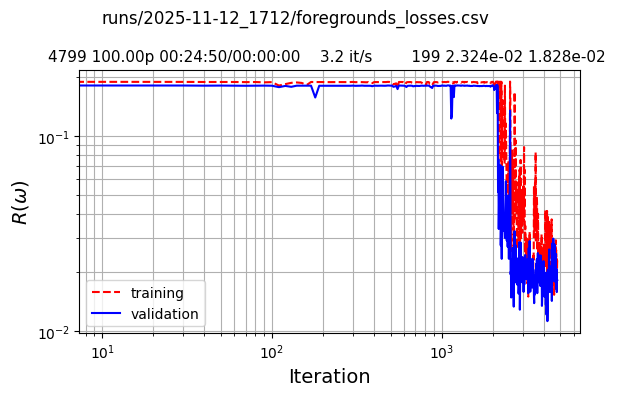

In [ ]:
importlib.reload(mlp)
importlib.reload(mon)

train(objective, optimizer, scheduler,
      train_loader, train_loader_val, val_loader,
      config)

monitor = mon.Monitor(config('file/losses'))
monitor.plot()